In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow import zeros_like, ones_like, function, GradientTape
from tensorflow.train import Checkpoint
from tensorflow.random import normal
from tensorflow.keras.optimizers import Adam
from IPython import display
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2023-03-07 15:14:16.603601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 15:14:17.338929: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 15:14:17.338965: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-07 15:14:18.755838: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Preprocessing

In [2]:
#BUFFER_SIZE = 60000 #seed for shuffling?
BATCH_SIZE = 4
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = normal([num_examples_to_generate, noise_dim])

2023-03-07 15:14:20.917211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-07 15:14:20.917488: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 15:14:20.917551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-07 15:14:20.917617: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-07 15:14:20.917666: W tensorf

## Generator

In [3]:
def make_generator_model() :

    #Establish the sequential model
    model = Sequential()

    #Start from latent space (REMEMBER - GENERATOR ARCHITECTURE MUST MIRROR DISCRIMINITOR ARCHITECTURE)
    #Noise comes in as (100,0) vector
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))

    #Transformer - Transforms output so that mean output -> 0 and SD output -> 1
    model.add(layers.BatchNormalization())

    #Activator - weights for generating an image?
    model.add(layers.LeakyReLU())

    #Reshape - first step towards final image size (separate out neurons)
    model.add(layers.Reshape((7, 7, 256)))

    #Check that output is correct shape
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    #Deconvolute from 7x7x256 to 7x7x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))

    #Check that output is correct shape
    assert model.output_shape == (None, 7, 7, 128)

    #Transformer - Transforms output so that mean output -> 0 and SD output -> 1
    model.add(layers.BatchNormalization())

    #Activator - weights for generating an image?
    model.add(layers.LeakyReLU())

    #Deconvolute from 7x7x128 to 14x14x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))

    #Check that output is correct shape
    assert model.output_shape == (None, 14, 14, 64)

    #Transformer - Transforms output so that mean output -> 0 and SD output -> 1
    model.add(layers.BatchNormalization())

    #Activator - weights for generating an image?
    model.add(layers.LeakyReLU())

    #Deconvolute from 14x14x64 to 28x28x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    #Transformer - Transforms output so that mean output -> 0 and SD output -> 1
    model.add(layers.BatchNormalization())

    #Activator - weights for generating an image?
    model.add(layers.LeakyReLU())

    #Deconvolute from 28x28x64 to 56x56x3
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    assert model.output_shape == (None, 56, 56, 3)

    return model


In [4]:
generator = make_generator_model()

In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

## Discriminator

In [6]:
def make_discriminator_model():
    model = Sequential([
        layers.Conv2D(64, (5,5), strides=(2, 2), padding='same', input_shape=[56, 56 , 3]),
#         layers.MaxPool2D(pool_size = (2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.4),
        
        
        layers.Conv2D(128, (3,3), strides = (2,2), padding = 'same'),
        layers.LeakyReLU(),
        layers.Dropout(0.4),
        
        layers.Flatten(),
        layers.Dense(1, activation = 'sigmoid' )])

    return model

In [7]:
discriminator = make_discriminator_model()

In [8]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 flatten (Flatten)           (None, 25088)            

## Loss and Optimizers

### Dicsriminator loss:

In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = BinaryCrossentropy(from_logits=True)

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(ones_like(real_output), real_output)
    fake_loss = cross_entropy(zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss:

In [11]:
def generator_loss(fake_output):
    return cross_entropy(ones_like(fake_output), fake_output)

### Optimizers: 

In [12]:
generator_optimizer = Adam(learning_rate = 0.1)
discriminator_optimizer = Adam(learning_rate = 0.1)

## Checkpoints

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

### Training loops

In [14]:
@function
def train_step(images):
    noise = normal([BATCH_SIZE, noise_dim])

    with GradientTape() as gen_tape, GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Train function

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 255)
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch}.png',)
    plt.show()

In [16]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Save the model every 10 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            display.clear_output(wait=True)
            generate_and_save_images(generator,epoch + 1, seed)
            
      # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator,epochs, seed)

In [17]:
test_folder = '/home/paulylydia/code/LimesAndCrimes/project_liminal/data'

In [18]:
from tensorflow.data import Dataset
from tensorflow.keras import utils
import pathlib

In [19]:
directory = '/home/paulylydia/code/LimesAndCrimes/project_liminal/data'

ds = utils.image_dataset_from_directory(
    directory,
    labels=None,
    color_mode='rgb',
    batch_size=5,
    image_size=(56, 56),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 9 files belonging to 1 classes.


In [20]:
len(ds)

2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

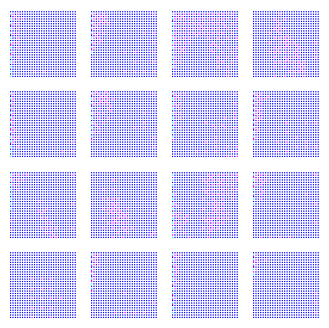

In [21]:
test_output1 = train(ds, EPOCHS)

In [22]:
generator()

ValueError: The first argument to `Layer.call` must always be passed.

In [ ]:
seed = normal([num_examples_to_generate, noise_dim])

In [ ]:
predictions = generator(seed, training=False)

In [ ]:
plt.imshow(predictions[0, :, :, :] * 255)